<center><FONT SIZE='+4'>CCD for the pairing model</FONT><br> 
<FONT SIZE='+2'>Group 2: Chencan Wang, Yiping Xu, and Jan Hoppe</FONT></center>

In [1]:
import numpy as np
#from sympy import *
import math, sys, os, glob
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator

sys.setrecursionlimit(30000)

In [2]:
#give input values
#where lines means degenerate states
particle = 4
line = 4
delta = 1.0

coupling = np.linspace(-0.6,1.2,19)

ecorrCCD=[]
ecorrFCI=[]

In [3]:
for gval in coupling:
	print('coupling strength ', gval, '\n')
	# set the particles to pairs
	pair = particle/2
	if(particle%2 != 0):
		print('Odd number of particles.')
		exit(0)

	if(pair>line):
		print('Wrong configuration.')
		exit(0)

	if(pair==1):
		states=[ i for i in range(line)]
	elif(pair==2):
		states = [(i,j) for i in range(line)
		                for j in range(i,line) if j!=i]
	elif(pair==3):
		states = [(i,j,k) for i in range(line)
		                  for j in range(i,line)
		                  for k in range(j,line)
		                  if j!=i and k!=j]
	elif(pair==4):
		states = [(i,j,k,l) for i in range(line)
		                    for j in range(i,line)
		                    for k in range(j,line)
		                    for l in range(k,line)
		                    if j!=i and k!=j and l!=k]

	elif(pair==5):
		states = [(i,j,k,l,m) for i in range(line)
		                      for j in range(i,line)
		                      for k in range(j,line)
		                      for l in range(k,line)
		                      for m in range(l,line)
		                      if j!=i and k!=j and l!=k and m!=l]

	config_num  = len(states)
	#print('There are %d states: \n'  %config_num)
	#print(states)

	# evaluate the sp operator
	def h_sp(A):
		if(pair==1):
			return A
		else:
			return sum(A)

	# evaluate the pair term
	def h_pr(A,B):
		if(pair==1):
			if(A==B):
				return 2
			else:
				return 1
		else:
			if(len(A)!=len(B)):
				print('Something wrong.')
				exit(0)
			elif(pair!=1):
				n = len(A)
			s1 = set(A)
			s2 = set(B)
			m = len(s1&s2)

			if(n==m):
				return 2
			elif(n - m ==1):
				return 1
			else:
				return 0

	# initialize a unit matrix with define dimension
	H = np.eye(config_num)

	Hc= [ ['123' for i in range(config_num)]
	      for i in range(config_num)]

	# The form of the matrix...
	#print('The form of the matrix is: \n')
	for i in range(config_num):
		for j in range(config_num):
			Hc[i][j]='-'+str(int(h_pr(states[i],states[j])))+'g'
			if(i==j):
				Hc[i][j] = Hc[i][j] \
	                   + '+' \
				       + str(int(2*delta*h_sp(states[i])))   \
				       +'d'

	#for i in range(len(states)):
	#	print(Hc[i])



	egv = [] # as the eigenvalue of H
	crt = [] # as the correlation energy

	# find the minimum of the eigenvalues
	#for g in coupling:

	# construction of the Hamiltonian
	for i in range(config_num):
		for j in range(config_num):
			H[i,j]=-gval*h_pr(states[i],states[j])
			if(i==j):
				H[i,j] = H[i,j] + 2*delta*h_sp(states[i])

	    # get the eigenvalues of H
	u, v = np.linalg.eig(H)
	egv.append(min(u))

	if(pair==1):
		crt.append(min(u) + 2*gval)
	else:
		crt.append(min(u)- sum(states[0])*2*delta + 2*gval)
	print('\n', 'correlation energy by FCI     ', round(crt[0],4), '\n')
	ecorrFCI.append(crt[0])

	#####----set new part for CCD of pairing model----#####

	#set fermi level, start counting states at 0
	def flevel(number):
	    return number-1

	#set valence space defined by total number of lines, start counting at 0
	def exspace(levels):
	    return (2*levels)-1

	fermi=flevel(particle)
	vspace=exspace(line)

	#fockt matrix, single particle part contributes only for diagonal
	def fpq(p,q,gval):
		if p != q:
			return 0
		elif p in range(particle):
			return math.floor((p)/2.0)*delta - gval
		else:
			return math.floor((p)/2.0)*delta

	#define two-body interaction and check of a,b and i,j are paired
	#imply antisymmety for different cases
	def vint(a,b,i,j,gval):
		if math.floor(a/2.0) == math.floor(b/2.0) and math.floor(i/2.0) == math.floor(j/2.0) and a!=b and i!=j:
			if a < b and i < j:
				return -gval
			if a < b and i > j:
				return gval
			if a > b and i < j:
				return gval
			if a > b and i > j:
				return -gval
		else:
			return 0

	#differ pppp pphh (transpose to hhpp) and V_hhhh
	#start counting a and b from Fermi level, so substract fermilevel in array
	v_pphh = np.zeros(shape=(vspace-fermi, vspace-fermi, fermi+1, fermi+1))
	v_pppp = np.zeros(shape=(vspace-fermi, vspace-fermi, vspace-fermi, vspace-fermi))
	v_hhhh = np.zeros(shape=(fermi+1, fermi+1, fermi+1, fermi+1))

	for matrix in (v_pphh, v_pppp, v_hhhh):
		for a in range(np.size(matrix,0)):
			for b in range(np.size(matrix,1)):
				for i in range(np.size(matrix,2)):
					for j in range(np.size(matrix,3)):
						matrix[a,b,i,j]=vint(a,b,i,j,gval)
	v_hhpp = v_pphh.T

	#defining the two fock matrices
	f_hh=np.zeros(shape=(fermi+1,fermi+1))
	f_pp=np.zeros(shape=(vspace-fermi,vspace-fermi))

	for p in range(np.size(f_hh,0)):
		for q in range(np.size(f_hh,1)):
			f_hh[p,q] = fpq(p,q,gval)

	for p in range(np.size(f_pp,0)):
		for q in range(np.size(f_pp,1)):
			f_pp[p,q] = fpq(p+particle,q+particle,gval)

	#define T2 array for starting point, e.g. PT
	tstart= np.zeros(shape=(vspace-fermi,vspace-fermi,fermi+1,fermi+1))
	#set up Hamiltonian
	hbar= np.zeros(shape=(vspace-fermi,vspace-fermi,fermi+1,fermi+1))

	#starting point from PT for t0
	for a in range(np.size(tstart,0)):
		   for b in range(np.size(tstart,1)):
			   for i in range(np.size(tstart,2)):
				   for j in range(np.size(tstart,3)):
					   tstart[a,b,i,j]= -v_pphh[a,b,i,j] / (f_pp[a,a]+f_pp[b,b]-f_hh[i,i]-f_hh[j,j])

	#initialize division matrix in recursive formel for t
	fsum= np.zeros(shape=(vspace-fermi,vspace-fermi,fermi+1,fermi+1))
	for a in range(np.size(fsum,0)):
			  for b in range(np.size(fsum,1)):
				  for i in range(np.size(fsum,2)):
					  for j in range(np.size(fsum,3)):
						  fsum[a,b,i,j]= f_pp[a,a]+f_pp[b,b]-f_hh[i,i]-f_hh[j,j]
	mix=0.3
	def tfunc(t):
		#intermediate chis for diagrams 7,8,9, and 10
		intermedchi_alid= 1/2.0*np.einsum('klcd,acik->alid', v_hhpp, t)
		intermedchi_li= 1/2.0*np.einsum('klcd,cdik->li', v_hhpp, t)
		intermedchi_ad= 1/2.0*np.einsum('klcd,ackl->ad', v_hhpp, t)
		intermedchi_klij= 1/4.0*np.einsum('klcd,cdij->klij', v_hhpp, t)

		hbar= v_pphh \
		 	+ np.einsum('bc,acij->abij', f_pp, t) - np.einsum('ac,bcij->abij', f_pp, t) \
			- np.einsum('kj,abik->abij', f_hh, t) + np.einsum('ki,abjk->abij', f_hh, t) \
			+ 1/2.0*np.einsum('abcd,cdij->abij', v_pppp, t) \
			+ 1/2.0*np.einsum('klij,abkl->abij', v_hhhh, t) \
			+ np.einsum('alid,dblj->abij', intermedchi_alid, t) - np.einsum('blid,dalj->abij', intermedchi_alid, t) \
			- np.einsum('aljd,dbli->abij', intermedchi_alid, t) + np.einsum('bljd,dali->abij', intermedchi_alid, t) \
			+ np.einsum('li,ablj->abij', intermedchi_li, t) - np.einsum('lj,abli->abij', intermedchi_li, t) \
			+ np.einsum('ad,dbij->abij', intermedchi_ad, t) - np.einsum('bd,daij->abij', intermedchi_ad, t) \
			+ np.einsum('klij,abkl->abij', intermedchi_klij, t)

#		t = t - hbar / fsum
		t = t - mix*(hbar / fsum)
		return t
	#iterative function to return new correlation energy
	def iterative(t):
		ecorr= 1/4.0*np.einsum('ijab,abij->', v_hhpp, t)
		tnew=tfunc(t)
		ecorrnew= 1/4.0*np.einsum('ijab,abij->', v_hhpp, tnew)
		return (ecorrnew, abs(ecorr-ecorrnew), tnew)

	#set maximal steps of iterations and convergence criterium
	itermax=200
	eps=0.00001
	titer=tstart

	for iter in range(itermax):
		t=titer
		result=iterative(t)
		ecorr=result[0]
		deltecorr=result[1]
		if iter < 10:
			print('step ', iter, '   correlation energy  ', round(ecorr,4), '  delta E  ', round(deltecorr,4))
		elif iter > 9:
			print('step ', iter, '  correlation energy  ', round(ecorr,4), '  delta E  ', round(deltecorr,4))
		elif iter > 99:
			print('step ', iter, ' correlation energy  ', round(ecorr,4), '  delta E  ', round(deltecorr,4))
		titer=result[2]
		if deltecorr < eps:
			break
		if iter == itermax-1 and deltecorr > eps:
			print('!!! no convergeged results after ', iter + 1, ' iteration steps !!!')

	print('difference of FCI and CCD  ' ,round(abs(ecorr-crt[0]),10), '\n')
	ecorrCCD.append(ecorr)

coupling strength  -0.6 


 correlation energy by FCI      -0.3012 

step  0    correlation energy   -0.2815   delta E   0.5006
step  1    correlation energy   -0.3113   delta E   0.0297
step  2    correlation energy   -0.3069   delta E   0.0044
step  3    correlation energy   -0.3032   delta E   0.0036
step  4    correlation energy   -0.3012   delta E   0.002
step  5    correlation energy   -0.3001   delta E   0.0011
step  6    correlation energy   -0.2995   delta E   0.0006
step  7    correlation energy   -0.2992   delta E   0.0003
step  8    correlation energy   -0.299   delta E   0.0002
step  9    correlation energy   -0.2989   delta E   0.0001
step  10   correlation energy   -0.2988   delta E   0.0001
step  11   correlation energy   -0.2988   delta E   0.0
step  12   correlation energy   -0.2988   delta E   0.0
step  13   correlation energy   -0.2988   delta E   0.0
difference of FCI and CCD   0.0024238008 

coupling strength  -0.5 


 correlation energy by FCI      -0.2201 

step

step  21   correlation energy   -0.7585   delta E   0.0011
step  22   correlation energy   -0.7594   delta E   0.0009
step  23   correlation energy   -0.7601   delta E   0.0007
step  24   correlation energy   -0.7607   delta E   0.0006
step  25   correlation energy   -0.7612   delta E   0.0005
step  26   correlation energy   -0.7616   delta E   0.0004
step  27   correlation energy   -0.7619   delta E   0.0003
step  28   correlation energy   -0.7621   delta E   0.0003
step  29   correlation energy   -0.7624   delta E   0.0002
step  30   correlation energy   -0.7625   delta E   0.0002
step  31   correlation energy   -0.7627   delta E   0.0001
step  32   correlation energy   -0.7628   delta E   0.0001
step  33   correlation energy   -0.7629   delta E   0.0001
step  34   correlation energy   -0.763   delta E   0.0001
step  35   correlation energy   -0.763   delta E   0.0001
step  36   correlation energy   -0.7631   delta E   0.0001
step  37   correlation energy   -0.7631   delta E   0.0
st

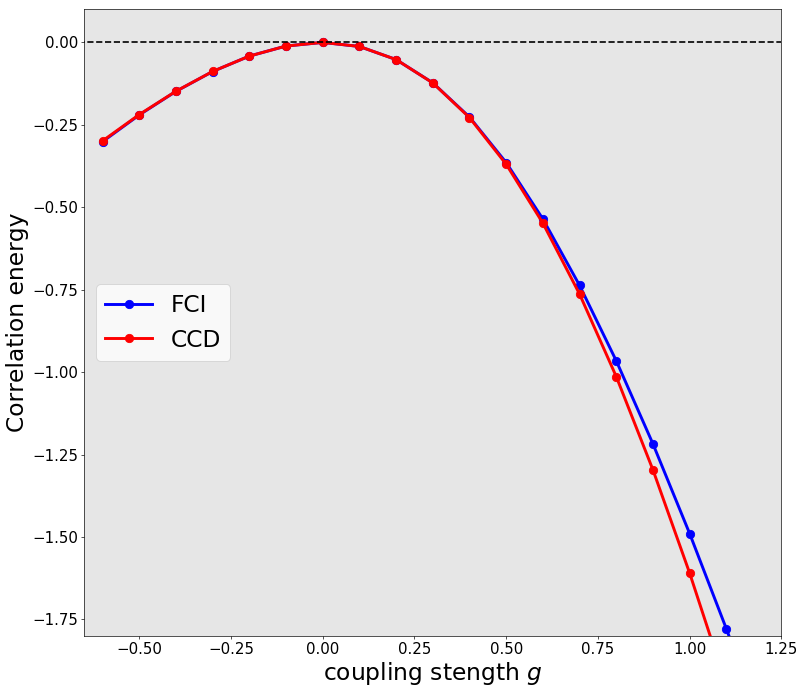

In [5]:
fig=plt.figure(figsize=(14,12),dpi=60)
fig.subplots_adjust(left=0.14, right=0.97, bottom=0.11, top=0.98)
ax=fig.add_subplot(1, 1, 1)
ax.set_facecolor('0.9')

plt.plot(coupling,ecorrFCI,'b-o',lw=3.5, markersize=10, label='FCI')
plt.plot(coupling,ecorrCCD, 'r-o',lw=3.5, markersize=10, label='CCD')
plt.plot((-2,2),(0,0),'b--', color='black',lw=2.0)
plt.xlim(-0.65,1.25)
plt.ylim(-1.8,0.1)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.xlabel('coupling stength $g$ ',fontsize=28)
plt.ylabel('Correlation energy',fontsize=28)
plt.legend(loc='center left', fontsize=14,ncol=1,markerscale=1,numpoints=1,prop={'size':28})

plt.savefig('comp_FCI_CCD_pairing.pdf',format='pdf')